In [9]:
import sys
from comet_ml import Experiment
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchinfo import summary
import os

# Local imports
sys.path.append("/Users/leo/Programming/Thesis/utils")
sys.path.append("/Users/leo/Programming/Thesis/models")

from helper_functions import (delete_ds_store,plot_metrics,test,train,mean_std_finder,load_model)
from data_loader import ImageNetDataset
from MBNV3 import MBNV3_Creator
from config import comet_token, project_name, workspace
from torchvision.models import (mobilenet_v3_small, MobileNet_V3_Small_Weights as weights_small)

# Setting the seed for reproducibility
torch.manual_seed(42)

In [ ]:
prms = {
    "backbone": mobilenet_v3_small,
    "weights": None,
    "module": None,
    "module_alias": "SE",
    "data_path": "/Users/leo/Programming/Thesis/data/ImageNet_25/",
    "batch_size": 32,
    "img_size": 224,
    "num_classes": 25,
    "epochs": 50,
    "learning_rate": 0.001,
    "device": "mps",
    "model": None,
    "experiment": Experiment(api_key=comet_token, project_name=project_name, workspace=workspace, log_code=True),
    "load_model": False,
}
prms["model_save_path"] = f"./saved_weights/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

model = prms["model"] = MBNV3_Creator(prms["num_classes"], prms["device"], prms["module"])
delete_ds_store(prms["data_path"])

In [11]:
#mean, std = mean_std_finder(prms["data_path"])
#mean, std = torch.tensor([0.5235, 0.4358, 0.3905]), torch.tensor([0.2993, 0.2770, 0.2729]) # VGG
mean, std = torch.tensor([0.485, 0.456, 0.406]), torch.tensor([0.229, 0.224, 0.225]) # ImageNet
print(f"Mean: {mean}, Std: {std}")  

train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

Mean: tensor([0.4850, 0.4560, 0.4060]), Std: tensor([0.2290, 0.2240, 0.2250])


In [12]:
root_dir = "/Users/leo/Programming/Thesis/data/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC"
train_solution_file = "/Users/leo/Programming/Thesis/data/imagenet-object-localization-challenge/LOC_train_solution.csv"
val_solution_file = "/Users/leo/Programming/Thesis/data/imagenet-object-localization-challenge/LOC_val_solution.csv"

# Before creating the datasets, create the synset mapping:
synset_mapping_path = "/Users/leo/Programming/Thesis/data/imagenet-object-localization-challenge/LOC_synset_mapping.txt"
with open(synset_mapping_path, "r") as f:
    synset_mapping1 = {line.split()[0]: i for i, line in enumerate(f.readlines())}

root_dir = os.path.join(root_dir, "train")

# Create the datasets
train_dataset = ImageNetDataset(csv_file=train_solution_file, root_dir=root_dir, synset_mapping=synset_mapping1, transform=train_transform)
val_dataset = ImageNetDataset(csv_file=val_solution_file, root_dir=os.path.join(root_dir, "val"), synset_mapping=synset_mapping1, transform=test_transform, train=False)

# Create the DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=prms["batch_size"], shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=prms["batch_size"], shuffle=False, num_workers=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


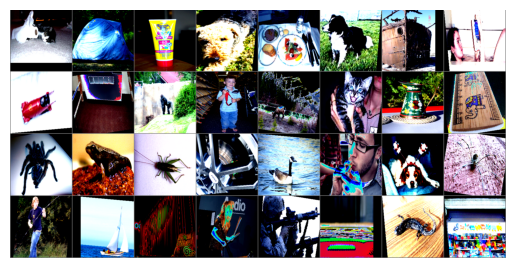

In [13]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
# set the seed for reproducibility
torch.manual_seed(42)

dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [14]:
#build the model
model.build_model()
model = prms["model"].to(prms["device"])


# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 40], gamma=0.1)

prms["experiment"].log_parameters({"loss": criterion, "optimizer": optimizer}) if prms["experiment"] else None

SE block in layers: [1, 4, 5, 6, 7, 8, 9, 10, 11].
Model weights initialized with Xavier initialization.


In [15]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MBNV3_Creator (MBNV3_Creator)                                     [1, 3, 224, 224]     [1, 25]              --                   --                   --                   True
├─MobileNetV3 (model)                                             [1, 3, 224, 224]     [1, 25]              --                   --                   --                   True
│    └─Sequential (features)                                      [1, 3, 224, 224]     [1, 576, 7, 7]       --                   --                   --                   True
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 16, 112, 112]    --                   --                   --                   True
│    │    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 16, 112, 112]    432    

In [ ]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, scheduler, hyper_params = prms, verbose = 2, test_transform = train_transform, experiment=prms["experiment"])

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)